In [1]:
import numpy as np
import scipy.integrate as scint
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")
from sparse_cyclic import legendre_dictionary

In [2]:
def lorenz96(t, u, F):
    """lorenz 96 dynamical system evolution function"""
    return (np.roll(u, -1) - np.roll(u, 2)) * np.roll(u, 1) - u + F

## Construct the data matrix U and Velocity Vector V



In [3]:
# number of equations in the ODE system
n = 128

# constant in the ODE system
F = 8

# step size
dt = 0.001

# terminal time -- one time step
T = dt

# number of bursts
K = 2

# noise level
var = 0.0001

# size of the block
nb = 55

# index of the first point of the block
ii = 1

# optimization parameters (for step 7)
tau = 1
mu = 1.0/2.0
max_it = 1E5
tol = 1E-7

In [4]:
# indices used in cyclic permutation and restriction of the data
r = int((nb - 1.0) / 2.0)

In [5]:
indc = np.arange(0, n)
indc = np.hstack([indc[0:r+1], indc[n-r:n]])
indc = np.sort(indc)

In [6]:
indr = np.arange(0, n)
indr = indr[ii-1:ii+nb-1]

In [7]:
nc = len(indc)
nr = len(indr)

In [8]:
# initialization
U = np.zeros((nr*K, nc))
Udot = np.zeros((nr*K, 1))
V = np.zeros((nr*K, 1))

In [9]:
for k in range(K):
    # random initial data
    u0 = 2*np.random.rand(n,1)-1
    
    # solve IVP to evolve the system
    sol = scint.solve_ivp(
        lambda t,x: lorenz96(t, x, F), 
        (0, T), 
        u0.flatten(), 
        t_eval=np.arange(0, T+T/10.0, T/2.0)
    )
    
    # get the actual derivative
    udot = lorenz96(0, u0, F)
    
    # collect just the first and last
    u = sol.y[:, (0, -1)].T
    
    # add noise to data
    u = u + var*np.random.randn(2, n)
    
    # compute the numerical derivative
    udot1 = (u[1,:] - u[0,:] )/dt
    
    v = np.zeros((n, n))
    v[0, :] = u[0, :]
    for j in range(1, n):
        v[j, :] = np.roll(v[j-1, :], [0, -1])
    #plt.imshow(v[indr, :][:, indc])

    U[(k)*nr : (k+1)*nr, :] = v[indr, :][:, indc]
    Udot[(k)*nr : (k+1)*nr, :] = udot[indr]
    V[(k)*nr : (k+1)*nr, :] = udot1[indr, np.newaxis]

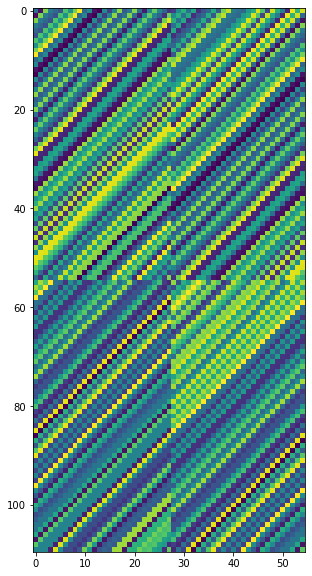

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(U)

# Transform U

In [11]:
# nothing to do here for this example...
a = 1
b = 0
U1 = np.copy(U)

# Construct the Dictionary matrix

Given a single measurement $u_0(t_0; k) \in \mathbb R^n$ we can obtain multiple measurements by considering the collection of all cyclic permutations of the data,

\begin{equation}
U\left(t_0 ; k\right)=\left(\begin{array}{cccc}
u_1\left(t_0 ; k\right) & u_2\left(t_0 ; k\right) & \cdots & u_n\left(t_0 ; k\right) \\
u_2\left(t_0 ; k\right) & u_3\left(t_0 ; k\right) & \cdots & u_1\left(t_0 ; k\right) \\
u_3\left(t_0 ; k\right) & u_4\left(t_0 ; k\right) & \cdots & u_2\left(t_0 ; k\right) \\
\vdots & \vdots & \ddots & \vdots \\
u_n\left(t_0 ; k\right) & u_1\left(t_0 ; k\right) & \cdots & u_{n-1}\left(t_0 ; k\right)
\end{array}\right)
\end{equation}

To make the dictionary matric, we can collect all monomials of $U$, such as 

\begin{equation}
U^2\left(t_0 ; k\right)=\left(\begin{array}{cccc}
u_1^2\left(t_0 ; k\right) & u_1\left(t_0 ; k\right) u_2\left(t_0 ; k\right) & \cdots & u_n^2\left(t_0 ; k\right) \\
u_2^2\left(t_0 ; k\right) & u_2\left(t_0 ; k\right) u_3\left(t_0 ; k\right) & \cdots & u_1^2\left(t_0 ; k\right) \\
u_3^2\left(t_0 ; k\right) & u_3\left(t_0 ; k\right) u_4\left(t_0 ; k\right) & \cdots & u_2^2\left(t_0 ; k\right) \\
\vdots & \vdots & \ddots & \vdots \\
u_n^2\left(t_0 ; k\right) & u_n\left(t_0 ; k\right) u_1\left(t_0 ; k\right) & \cdots & u_{n-1}^2\left(t_0 ; k\right)
\end{array}\right)
\end{equation}

and 

\begin{equation}
U^3\left(t_0 ; k\right)=\left(\begin{array}{cccccc}
u_1^3\left(t_0 ; k\right) & u_1^2\left(t_0 ; k\right) u_2\left(t_0 ; k\right) & \cdots & u_1\left(t_0 ; k\right) u_2\left(t_0 ; k\right) u_3\left(t_0 ; k\right) & \cdots & u_n^3\left(t_0 ; k\right) \\
u_2^3\left(t_0 ; k\right) & u_2^2\left(t_0 ; k\right) u_3\left(t_0 ; k\right) & \cdots & u_2\left(t_0 ; k\right) u_3\left(t_0 ; k\right) u_4\left(t_0 ; k\right) & \cdots & u_1^3\left(t_0 ; k\right) \\
u_3^3\left(t_0 ; k\right) & u_3^2\left(t_0 ; k\right) u_4\left(t_0 ; k\right) & \cdots & u_3\left(t_0 ; k\right) u_4\left(t_0 ; k\right) u_5\left(t_0 ; k\right) & \cdots & u_2^3\left(t_0 ; k\right) \\
\vdots & \vdots & \ddots & \vdots & \ddots & \vdots \\
u_n^3\left(t_0 ; k\right) & u_n^2\left(t_0 ; k\right) u_1\left(t_0 ; k\right) & \cdots & u_n\left(t_0 ; k\right) u_1\left(t_0 ; k\right) u_2\left(t_0 ; k\right) & \cdots & u_{n-1}^3\left(t_0 ; k\right)
\end{array}\right)
\end{equation}

So, then we can construct a $n \times N, \quad N = {{n+p}\choose{p}}$,
\begin{equation}
A\left(t_0 ; k\right)=\left[\begin{array}{llllllll}
1 & \mid & U\left(t_0 ; k\right) & \mid & U^2\left(t_0 ; k\right) & \mid U^3\left(t_0 ; k\right) & \mid & \ldots
\end{array}\right]
\end{equation}

Due to the size of higher order polynomials, we stay with $p=3$.

Given the velocity for the $k$th burst
\begin{equation}
V=\left(\begin{array}{c}
V\left(t_0 ; 1\right) \\
V\left(t_1 ; 1\right) \\
\vdots \\
V\left(t_{m-1} ; 1\right) \\
V\left(t_0 ; 2\right) \\
V\left(t_1 ; 2\right) \\
\vdots \\
V\left(t_{m-1} ; 2\right) \\
\vdots \\
V\left(t_0 ; K\right) \\
V\left(t_1 ; K\right) \\
\vdots \\
V\left(t_{m-1} ; K\right)
\end{array}\right) \quad \text { and } \quad A=\left(\begin{array}{c}
A\left(t_0 ; 1\right) \\
A\left(t_1 ; 1\right) \\
\vdots \\
A\left(t_{m-1} ; 1\right) \\
A\left(t_0 ; 2\right) \\
A\left(t_1 ; 2\right) \\
\vdots \\
A\left(t_{m-1} ; 2\right) \\
\vdots \\
A\left(t_0 ; K\right) \\
A\left(t_1 ; K\right) \\
\vdots \\
A\left(t_{m-1} ; K\right)
\end{array}\right),
\end{equation}
the inverse problem is to find a $c=\left(c_1, c_2, \ldots, c_N\right)^T$ such that $V=Ac$. The size of A is $mnK \times N$.We assume that the burst is short enough and mainly provides a numerical estimate of the velocity.

In [12]:
p = 3
r = 10
Amon, Aleg, Ind1, Ind20, Ind11, Ind300, Ind210, Ind120, Ind11 = legendre_dictionary(U1, p, r)